/Users/dariapavlova/Documents/defi_trends_analysis/.ven311/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


✅ Final dataset loaded.
Train size: 1914, Test size: 479
Class distribution in training set:
 target
0.0    1905
1.0       9
Name: count, dtype: int64
Class distribution in test set:
 target
0.0    476
1.0      3
Name: count, dtype: int64
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best base model parameters: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best semantic model parameters: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}

Base model report:
              precision    recall  f1-score   support

   No Stress       0.99      1.00      1.00       476
      Stress       0.00      0.00      0.00         3

    accuracy                           0.99       479
   macro avg       0.50      0.50      0.50       479
weighted avg       0.99      0.99      0.99    

<Figure size 1200x800 with 0 Axes>

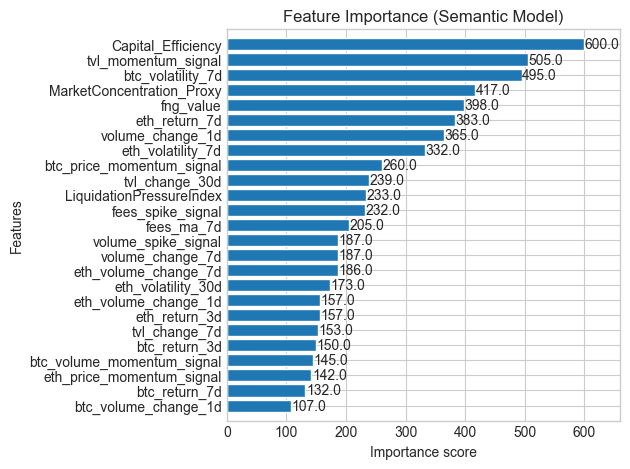

In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_auc_score, make_scorer
from sklearn.exceptions import FitFailedWarning
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance

# Define parameter grid
param_grid = {
    'n_estimators': [300, 500, 700, 1000],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# Custom safe scorer
def safe_roc_auc(y_true, y_score):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_score)

roc_auc_safe_scorer = make_scorer(safe_roc_auc, needs_proba=True)

# Load the dataset
try:
    df_final = pd.read_csv('../data/processed/big_data_for_learning.csv')
    df_final.sort_index(inplace=True)
    print("✅ Final dataset loaded.")
except FileNotFoundError:
    print("❌ Error: Dataset file not found.")
    df_final = pd.DataFrame()

if not df_final.empty and 'target' in df_final.columns:
    base_features = [
        'btc_return_1d', 'eth_return_1d', 'btc_return_3d', 'btc_return_7d', 'eth_return_3d', 'eth_return_7d',
        'btc_volatility_7d', 'eth_volatility_7d', 'btc_volatility_30d', 'eth_volatility_30d',
        'btc_price_momentum_signal', 'eth_price_momentum_signal', 'volume_change_1d', 'volume_change_7d',
        'volume_spike_signal', 'btc_volume_change_1d', 'btc_volume_change_7d', 'eth_volume_change_1d',
        'eth_volume_change_7d', 'btc_volume_momentum_signal', 'eth_volume_momentum_signal',
        'tvl_change_1d', 'tvl_change_7d', 'tvl_change_30d', 'tvl_momentum_signal',
        'fees_ma_7d', 'fees_spike_signal', 'fng_value'
    ]
    semantic_features = [
        'MarketConcentration_Proxy', 'ETH_Volatility_30d', 'LiquidationPressureIndex',
        'SentimentMomentum_7d', 'Capital_Efficiency'
    ]
    base_features = [col for col in base_features if col in df_final.columns]
    semantic_features = [col for col in semantic_features if col in df_final.columns]

    X = df_final[base_features + semantic_features]
    y = df_final['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print("Class distribution in training set:\n", y_train.value_counts())
    print("Class distribution in test set:\n", y_test.value_counts())

    if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
        print("❌ Error: One of the datasets contains only one class. Training cannot proceed.")
    else:
        smote = SMOTE(random_state=42)
        X_train_base_resampled, y_train_resampled = smote.fit_resample(X_train[base_features], y_train)
        X_train_semantic_resampled, _ = smote.fit_resample(X_train[base_features + semantic_features], y_train)

        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        tscv = TimeSeriesSplit(n_splits=5)

        base_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, eval_metric='logloss')
        search_base = RandomizedSearchCV(
            base_model, param_distributions=param_grid, n_iter=25,
            scoring=roc_auc_safe_scorer, cv=tscv, verbose=1, random_state=42, n_jobs=-1
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            warnings.simplefilter("ignore", category=FitFailedWarning)
            search_base.fit(X_train_base_resampled, y_train_resampled)

        best_model_base = search_base.best_estimator_
        print("Best base model parameters:", search_base.best_params_)

        semantic_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, eval_metric='logloss')
        search_semantic = RandomizedSearchCV(
            semantic_model, param_distributions=param_grid, n_iter=25,
            scoring=roc_auc_safe_scorer, cv=tscv, verbose=1, random_state=42, n_jobs=-1
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            warnings.simplefilter("ignore", category=FitFailedWarning)
            search_semantic.fit(X_train_semantic_resampled, y_train_resampled)

        best_model_semantic = search_semantic.best_estimator_
        print("Best semantic model parameters:", search_semantic.best_params_)

        def evaluate_with_threshold(model, X_eval, y_eval, name):
            probs = model.predict_proba(X_eval)[:, 1]
            precision, recall, thresholds = precision_recall_curve(y_eval, probs)
            f1_scores = 2 * precision * recall / np.where((precision + recall) == 0, 1, precision + recall)
            best_threshold = thresholds[np.argmax(f1_scores)]
            final_preds = (probs >= best_threshold).astype(int)
            print(f"\n{name} — optimal threshold: {best_threshold:.4f}")
            print(classification_report(y_eval, final_preds, target_names=["No Stress", "Stress"], zero_division=0))
            return precision, recall

        preds_base = best_model_base.predict(X_test[base_features])
        preds_semantic = best_model_semantic.predict(X_test[base_features + semantic_features])
        print("\nBase model report:")
        print(classification_report(y_test, preds_base, target_names=["No Stress", "Stress"], zero_division=0))
        print("\nSemantic model report:")
        print(classification_report(y_test, preds_semantic, target_names=["No Stress", "Stress"], zero_division=0))

        probs_base = best_model_base.predict_proba(X_test[base_features])[:, 1]
        probs_semantic = best_model_semantic.predict_proba(X_test[base_features + semantic_features])[:, 1]
        precision_base, recall_base, _ = precision_recall_curve(y_test, probs_base)
        precision_sem, recall_sem, _ = precision_recall_curve(y_test, probs_semantic)
        pr_auc_base = auc(recall_base, precision_base)
        pr_auc_sem = auc(recall_sem, precision_sem)
        print(f"\nPR AUC (Base): {pr_auc_base:.4f}, PR AUC (Semantic): {pr_auc_sem:.4f}")

        if pr_auc_sem > pr_auc_base * 1.05:
            print("✅ Hypothesis confirmed: Semantic features improved model.")
        else:
            print("⚠️ No significant improvement from semantic features.")

        evaluate_with_threshold(best_model_base, X_test[base_features], y_test, "Base model")
        evaluate_with_threshold(best_model_semantic, X_test[base_features + semantic_features], y_test, "Semantic model")

        plt.figure(figsize=(12, 8))
        plot_importance(best_model_semantic, height=0.8, max_num_features=25)
        plt.title("Feature Importance (Semantic Model)")
        plt.tight_layout()
        plt.show()

        joblib.dump(best_model_base, 'best_model_base.pkl')
        joblib.dump(best_model_semantic, 'best_model_semantic.pkl')
else:
    print("❌ DataFrame is empty or missing 'target' column.")